In [31]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import logging

In [32]:
# Configure logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create file handler to log to 'luka_bot.log'
file_handler = logging.FileHandler("luka_bot.log")
file_handler.setLevel(logging.INFO)

# Create console handler to log to the notebook output
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)

# Define logging format
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Add handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

# defining constants
GRAVITY = 9.81 # meters per second^2
HOOP_X = 7.24  # Distance from hoop to NBA 3pt line (in meters)
HOOP_Y = 3.05   # Hoop height (in meters)
BASKET_RADIUS = 0.2286  # Approx. basketball hoop radius (9 inches) in meters
BALL_RADIUS = 0.12065 # Approx. basketball radius (4.7 inches) in meters

In [36]:
'''
Helper function to convert height in feet into height in meters
'''
def feet_to_meters(feet):
    return feet * 0.3048  # Convert feet to meters

'''
Class definining the LukaBot environment
'''
class LukaBotEnv(gym.Env):
    '''
    Custom Environment that follows gym interface for LukaBot shooting simulation.
    Defines observation and action spaces for the player.
    Observation space: [Distance to hoop (m), height of release point (m)] -> realistic values for a basketball shot
    Action space: [Velocity (m/s) and angle (degrees)] -> preventing unrealistic flat shots or excessive speeds
    '''
    def __init__(self, player_height_ft=6.5): # Luka is 6'6
        super(LukaBotEnv, self).__init__()

        # training trackers
        self.current_episode = 0
        self.total_rewards = 0
        self.successful_shots = 0
        self._last_shot_info = {}
        self.state_history = []

        # enviornment attributes
        self.release_point_height = feet_to_meters(player_height_ft + 1) 
        self.observation_space = spaces.Box(low=np.array([0, 0, 0]), high=np.array([10, 10, 5]), dtype=np.float32)
        self.action_space = spaces.Box(low=np.array([5, 20]), high=np.array([30, 80]), dtype=np.float32)
        self.state = None
        self.reset()

    '''
    Environment is initialized with the necessary starting conditions 
    that LukaBot will use to learn how to adjust its shot mechanics.
    '''
    def reset(self, seed=None, options=None):
        self.current_episode += 1
        self.total_rewards = 0
        if self.current_episode % 1000 == 0:
            logger.info(f"Episode {self.current_episode}")
            logger.info(f"Total Rewards: {self.total_rewards}")
            logger.info(f"Successful Shots: {self.successful_shots}")
        self._last_shot_info = {
            'velocity': None,
            'angle': None,
            'distance': None,
            'height': None,
            'reward': None
        }
        self.state = np.array([np.random.uniform(5, 8), 0, self.release_point_height])
        return self.state, {}

    '''
    Custom reward function to evaluate the success of the shot attempt
    '''
    def calculate_reward(self, x, y):
        # Penalize for missing the hoop (hit the ground)
        if y <= 0:
            return -0.5

        distance_to_hoop = np.sqrt((x - HOOP_X)**2 + (y - HOOP_Y)**2)

        # Reward for making the shot
        x_distance_to_hoop = abs(x - HOOP_X)
        if x_distance_to_hoop <= (BASKET_RADIUS - BALL_RADIUS) and abs(y - HOOP_Y) <= 0.05:
            return 10  
        
        # Partial Reward if the shot is close but doesn't go in
        if distance_to_hoop < 0.1:  
            return 7
        if distance_to_hoop < 0.2:  
            return 5
        if distance_to_hoop < 0.3:  
            return 3
        elif distance_to_hoop < 0.5:  
            return 2 
        elif distance_to_hoop < 1.0:  
            return 1  

        # Negative reward for ball far away from the hoop
        return -1


    '''
    Simulates a shot attempt using the kinematic equations.
    '''
    def step(self, action):
        velocity, angle = action
        logger.info(f"Action received: {action}")
        
        angle = np.deg2rad(angle)  # Convert angle to radians
        v_x = velocity * np.cos(angle)  # Horizontal velocity
        v_y = velocity * np.sin(angle)  # Vertical velocity

        t = 0  
        dt = 0.01  
        max_time = 3  

        x = 0
        y = self.release_point_height
        done = False

        while t < max_time:
            x = v_x * t  
            y = self.release_point_height + v_y * t - 0.5 * GRAVITY * t**2  
            
            # Stop when the shot is finished (either made or missed)
            if y <= 0:  # Ball hit ground
                done = True
                break
            elif abs(x - HOOP_X) <= (BASKET_RADIUS - BALL_RADIUS) and abs(y - HOOP_Y) <= 0.05:  # Ball went in
                done = True
                break
            
            t += dt

        # Compute reward after the shot ends
        reward = self.calculate_reward(x, y)

        self._last_shot_info.update({
            'velocity': velocity,
            'angle': np.rad2deg(angle),
            'distance': x,
            'height': y,
            'reward': reward
        })

        logger.info(f"Shot Details: "
                    f"Velocity={velocity:.2f}m/s, "
                    f"Angle={np.rad2deg(angle):.2f}°, "
                    f"Distance={x:.2f}m, "
                    f"Height={y:.2f}m, "
                    f"Reward={reward}")

        distance_to_hoop = np.sqrt((x - HOOP_X)**2 + (y - HOOP_Y)**2)
        self.state = np.array([distance_to_hoop, x, y], dtype=np.float32)
        self.state_history.append(self.state)

        logger.info(f"Updated state: {self.state}, Reward: {reward}, Done: {done}")
        return self.state, reward, done, False, self._last_shot_info


In [37]:
def train_and_visualize(total_timesteps=50):
    """
    Train the PPO agent and visualize shot trajectories.
    
    Args:
        total_timesteps (int): Number of training timesteps
    """
    # Create environment
    env = LukaBotEnv()
    
    # Train PPO model
    model = PPO("MlpPolicy", env, learning_rate=0.001, gamma=0.98, n_steps=1024, ent_coef=0.3, 
            clip_range=0.2, verbose=1)
    model.learn(total_timesteps=total_timesteps, log_interval=100)

    # Test the trained model
    def test_agent(env, model, episodes=5):
        for episode in range(episodes):
            obs, _ = env.reset()
            done = False
            
            while not done:
                action, _ = model.predict(obs)
                print(f"Predicted Action: {action}")  # Debugging
                obs, reward, done, _, info = env.step(action)
                print(f"Observation After Action: {obs}, Reward: {reward}")
                
                # Visualize each shot
                if done:
                    print(f"\nEpisode {episode + 1}:")
                    print(f"Shot Velocity: {info['velocity']:.2f} m/s")
                    print(f"Shot Angle: {info['angle']:.2f} degrees")
                    print(f"Distance: {info['distance']:.2f} m")
                    print(f"Height: {info['height']:.2f} m")
                    print(f"Reward: {reward}")
                    
                    # Visualize the shot
                    plot_shot(info['velocity'], info['angle'])

    test_agent(env, model)

def plot_shot(velocity, angle):
    """
    Create a 2D visualization of a basketball shot trajectory.
    
    Args:
        velocity (float): Initial shot velocity in m/s
        angle (float): Shooting angle in degrees
    """
    # Simulation parameters
    release_height = feet_to_meters(7.6)  # Player height + arm extension
    angle_rad = np.radians(angle)
    t_values = np.linspace(0, 2, num=100)  # Time samples
    
    # Calculate trajectory
    x_values = velocity * np.cos(angle_rad) * t_values
    y_values = (release_height + 
                velocity * np.sin(angle_rad) * t_values - 
                0.5 * GRAVITY * t_values**2)
    
    # Plot trajectory
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_values, label=f"v={velocity:.2f}, θ={angle:.2f}°")
    plt.scatter([HOOP_X], [HOOP_Y], color='red', label='Hoop')
    plt.xlim(0, 10)
    plt.ylim(0, 5)
    plt.xlabel("Distance (m)")
    plt.ylabel("Height (m)")
    plt.title("Basketball Shot Trajectory")
    plt.legend()
    plt.grid(True)
    plt.show()

2025-03-25 13:36:55,297 - INFO - Action received: [ 5. 20.]
2025-03-25 13:36:55,297 - INFO - Action received: [ 5. 20.]
2025-03-25 13:36:55,297 - INFO - Action received: [ 5. 20.]
2025-03-25 13:36:55,299 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:36:55,299 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:36:55,299 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:36:55,301 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True
2025-03-25 13:36:55,301 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True
2025-03-25 13:36:55,301 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True
2025-03-25 13:36:55,305 - INFO - Action received: [ 5. 20.]
2025-03-25 13:36:55,305 - INFO - Action received: [ 5. 20.

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


2025-03-25 13:36:55,496 - INFO - Action received: [ 5. 20.]
2025-03-25 13:36:55,496 - INFO - Action received: [ 5. 20.]
2025-03-25 13:36:55,496 - INFO - Action received: [ 5. 20.]
2025-03-25 13:36:55,497 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:36:55,497 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:36:55,497 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:36:55,497 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True
2025-03-25 13:36:55,497 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True
2025-03-25 13:36:55,497 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True
2025-03-25 13:36:55,499 - INFO - Action received: [ 5. 20.]
2025-03-25 13:36:55,499 - INFO - Action received: [ 5. 20.

Predicted Action: [ 5. 20.]
Observation After Action: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5

Episode 1:
Shot Velocity: 5.00 m/s
Shot Angle: 20.00 degrees
Distance: 4.13 m
Height: -0.01 m
Reward: -0.5


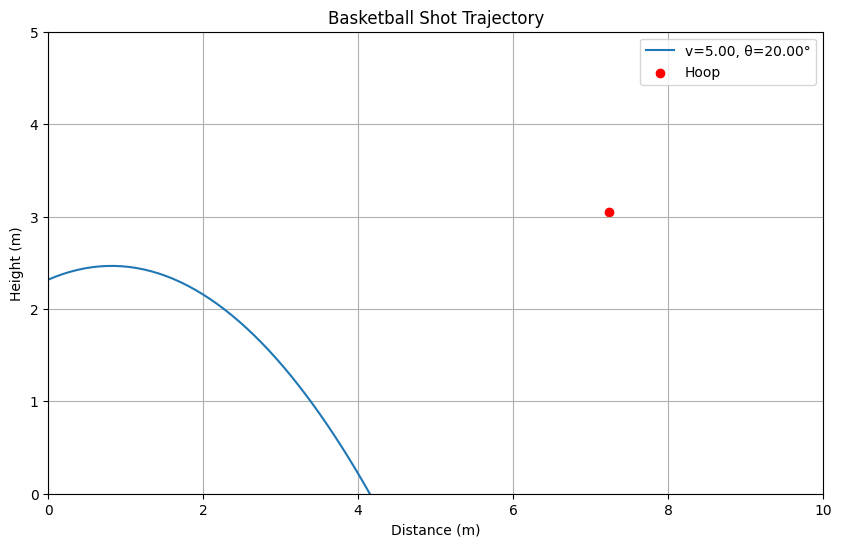

2025-03-25 13:37:00,005 - INFO - Action received: [ 5. 20.]
2025-03-25 13:37:00,005 - INFO - Action received: [ 5. 20.]
2025-03-25 13:37:00,005 - INFO - Action received: [ 5. 20.]
2025-03-25 13:37:00,006 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:37:00,006 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:37:00,006 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:37:00,008 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True
2025-03-25 13:37:00,008 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True
2025-03-25 13:37:00,008 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True


Predicted Action: [ 5. 20.]
Observation After Action: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5

Episode 2:
Shot Velocity: 5.00 m/s
Shot Angle: 20.00 degrees
Distance: 4.13 m
Height: -0.01 m
Reward: -0.5


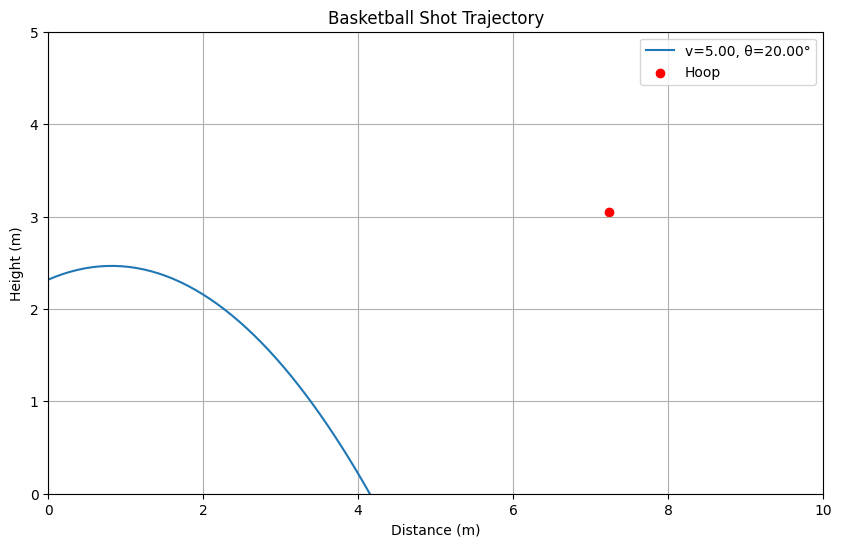

2025-03-25 13:37:00,069 - INFO - Action received: [ 5. 20.]
2025-03-25 13:37:00,069 - INFO - Action received: [ 5. 20.]
2025-03-25 13:37:00,069 - INFO - Action received: [ 5. 20.]
2025-03-25 13:37:00,070 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:37:00,070 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:37:00,070 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:37:00,071 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True
2025-03-25 13:37:00,071 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True
2025-03-25 13:37:00,071 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True


Predicted Action: [ 5. 20.]
Observation After Action: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5

Episode 3:
Shot Velocity: 5.00 m/s
Shot Angle: 20.00 degrees
Distance: 4.13 m
Height: -0.01 m
Reward: -0.5


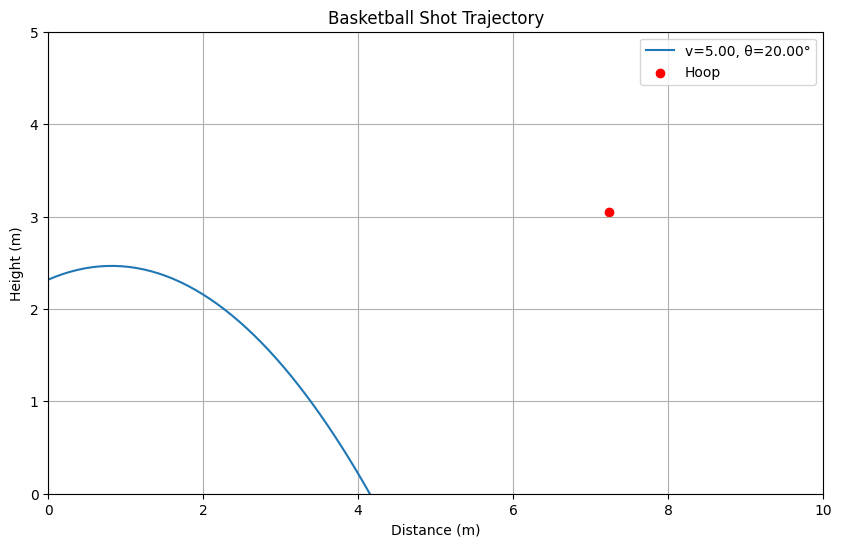

2025-03-25 13:37:00,135 - INFO - Action received: [ 5. 20.]
2025-03-25 13:37:00,135 - INFO - Action received: [ 5. 20.]
2025-03-25 13:37:00,135 - INFO - Action received: [ 5. 20.]
2025-03-25 13:37:00,136 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:37:00,136 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:37:00,136 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:37:00,137 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True
2025-03-25 13:37:00,137 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True
2025-03-25 13:37:00,137 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True


Predicted Action: [ 5. 20.]
Observation After Action: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5

Episode 4:
Shot Velocity: 5.00 m/s
Shot Angle: 20.00 degrees
Distance: 4.13 m
Height: -0.01 m
Reward: -0.5


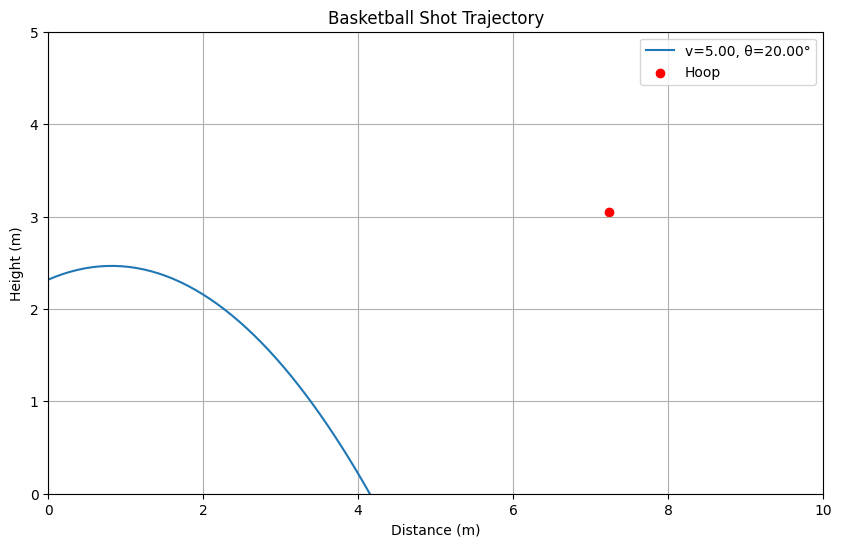

2025-03-25 13:37:00,196 - INFO - Action received: [ 5. 20.]
2025-03-25 13:37:00,196 - INFO - Action received: [ 5. 20.]
2025-03-25 13:37:00,196 - INFO - Action received: [ 5. 20.]
2025-03-25 13:37:00,197 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:37:00,197 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:37:00,197 - INFO - Shot Details: Velocity=5.00m/s, Angle=20.00°, Distance=4.13m, Height=-0.01m, Reward=-0.5
2025-03-25 13:37:00,198 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True
2025-03-25 13:37:00,198 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True
2025-03-25 13:37:00,198 - INFO - Updated state: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5, Done: True


Predicted Action: [ 5. 20.]
Observation After Action: [ 4.357957    4.1346474  -0.00754356], Reward: -0.5

Episode 5:
Shot Velocity: 5.00 m/s
Shot Angle: 20.00 degrees
Distance: 4.13 m
Height: -0.01 m
Reward: -0.5


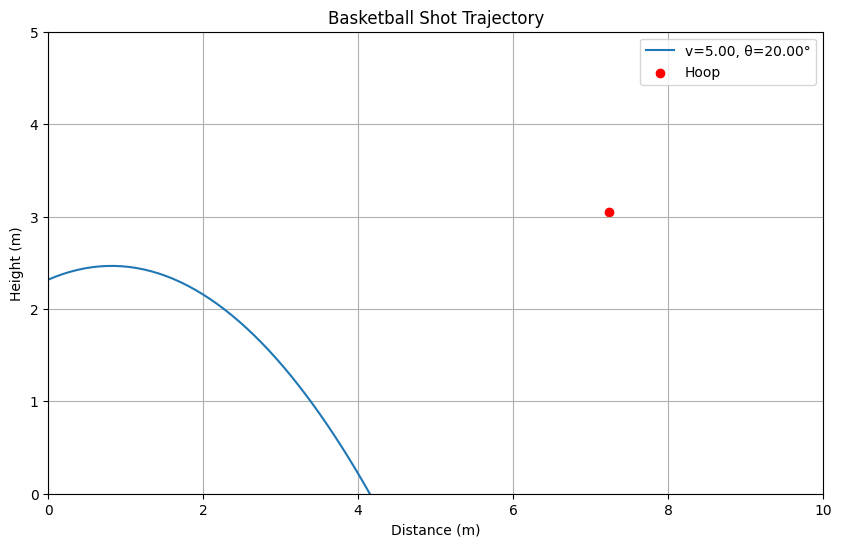

In [38]:
train_and_visualize()